## MazeRunner DataAnalyse
![image.png](attachment:image.png)

# GROTE VRAGEN:

## - Vinden de multiagents sneller de uitgang als ze samenwerken (auction)

## - 

In [101]:
import os
import glob
import pyarrow.feather as feather

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from analysis.helpers import plot_batch, read_data

In [89]:
os.getcwd()

os.chdir('../experiments')

os.getcwd()

'D:\\Git\\MazeRunner\\experiments'

## Baseline

Hierin kijken we welke van de 3 soorten agents in normale omstandigheden het stelste de uitgang vind. We kijken eerst naar een 'kleine' maze met afmetingen van 20x20 tiles

#### Klein doolhof

- 100 batches per policy
- Speed = 0
- Memory Decay = 0

In [91]:
df_lt = feather.read_feather('baseline/baseline_small/baseline_leaftracker_small.feather')
df_lt['policy'] = 'leaftracker'

df_pf = feather.read_feather('baseline/baseline_small/baseline_pathfinder_small.feather')
df_pf['policy'] = 'pathfinder'

df_pr = feather.read_feather('baseline/baseline_small/baseline_purerandom_small.feather')
df_pr['policy'] = 'purerandom'

baseline_small_all = pd.concat([df_lt, df_pf, df_pr], axis=0)

baseline_small_lt_pf = pd.concat([df_lt, df_pf], axis=0)

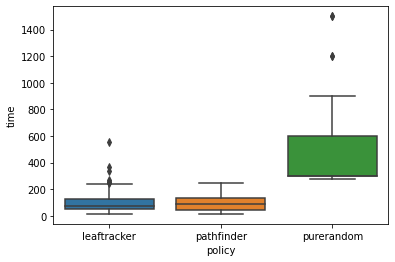

In [92]:
ax = sns.boxplot(x="policy", y="time", data=baseline_small_all)

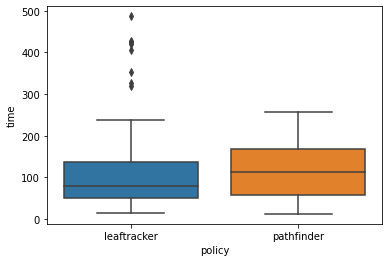

In [104]:
ax = sns.boxplot(x="policy", y="time", data=baseline_small_lt_pf)

#### Groot doolhof

- 30 batches per policy
- Speed = 0
- Memory Decay = 0

In [94]:
df_lt = feather.read_feather('baseline/baseline_big/baseline_leaftracker_big.feather')
df_lt['policy'] = 'leaftracker'

df_pf = feather.read_feather('baseline/baseline_big/baseline_pathfinder_big.feather')
df_pf['policy'] = 'pathfinder'

df_pr = feather.read_feather('baseline/baseline_big/baseline_purerandom_big.feather')
df_pr['policy'] = 'purerandom'

baseline_big_all = pd.concat([df_lt, df_pf, df_pr], axis=0)

baseline_big_lt_pf = pd.concat([df_lt, df_pf], axis=0)

In [99]:
df_pr

,time,found_exit,n_alive,explored,policy
0,600,-1,0,"[[[False, False, False, False, False, False, F...",purerandom


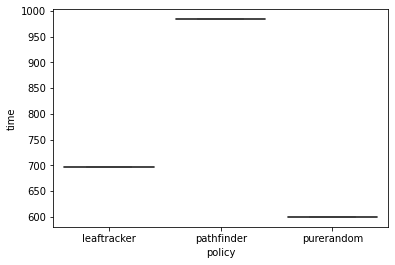

In [95]:
ax = sns.boxplot(x="policy", y="time", data=baseline_big_all)

### Leaftracker & Pathfinder

Omdat 

#### SLOWNESS

Bij deze analyse laten wij de verschilden snelheden zien van de policies om de uitgang te vinden

In [218]:
filenames = glob.glob('speed_difference/*.feather')

dfs = []
for filename in filenames:
    # print(filename)
    temp_df = feather.read_feather(filename)
    file_split = filename.split("_")
    policy_type = file_split[3]
    temp_df['slowness'] = int(file_split[4].rsplit(".")[0])
    temp_df['policy'] = policy_type
    dfs.append(temp_df)

# add policy    
    df_pf['policy'] = 'pathfinder'
# Concatenate all data into one DataFrame
speed_all = pd.concat(dfs, ignore_index=True)
speed_all = speed_all.sort_values(by=['slowness'])
speed_all_alive = speed_all[speed_all.found_exit != -1]


Alleen de agents die overleven en de uitgang vinden

Agent heeft steeds minder tijd om te exploren, daarom exponentieel

<AxesSubplot:xlabel='slowness', ylabel='time'>

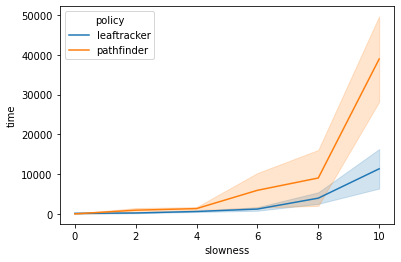

In [215]:
sns.lineplot(
    data=speed_all_alive, x="slowness", y="time", hue="policy", ci=68
)

## Memory decay

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [229]:
filenames = glob.glob('memory_decay/*.feather')

dfs = []
for filename in filenames:
    # print(filename)
    temp_df = feather.read_feather(filename)
    file_split = filename.split("_")
    policy_type = file_split[3]
    # print(file_split[4])
    temp_df['decay'] = int(file_split[4].rsplit(".")[0])
    temp_df['policy'] = policy_type
    dfs.append(temp_df)

# add policy    
    df_pf['policy'] = 'pathfinder'
# Concatenate all data into one DataFrame
decay_all = pd.concat(dfs, ignore_index=True)
decay_all = decay_all.sort_values(by=['decay'])

In [230]:
decay_all

,time,found_exit,n_alive,explored,decay,policy
0,869,0,1,"[[[True, True, True, True, True, True, True, T...",0,Pathfinder
58,875,0,1,"[[[True, True, True, True, True, True, True, T...",5,Pathfinder
57,753,0,1,"[[[True, True, True, True, True, True, True, T...",5,Pathfinder
56,633,0,1,"[[[True, True, True, True, True, True, True, T...",5,Pathfinder
55,511,0,1,"[[[True, False, True, True, True, True, True, ...",5,Pathfinder
...,...,...,...,...,...,...
47,2427,0,1,"[[[False, False, False, False, True, False, Fa...",30,Pathfinder
42,147,0,1,"[[[False, False, False, False, False, False, F...",30,Pathfinder
45,387,0,1,"[[[False, False, True, False, False, True, Tru...",30,Pathfinder
41,30,0,1,"[[[False, False, False, False, False, False, F...",30,Pathfinder


<AxesSubplot:xlabel='decay', ylabel='time'>

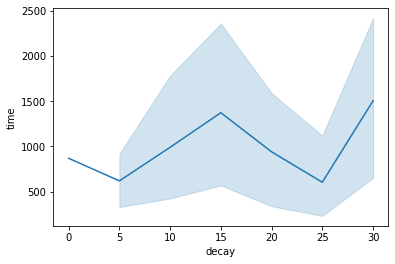

In [231]:
sns.lineplot(
    data=decay_all, x="decay", y="time"
)

![image-2.png](attachment:image-2.png)
